#### Data Cleaning

In [1]:
import pandas as pd
import duckdb
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from openpyxl import load_workbook

In [3]:
# db connection
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb',read_only=False)


### Create Table from csv file

In [ ]:
# Drop the tables if they exist
con.execute("DROP TABLE IF EXISTS multi_age_composite_dataset;")
con.execute("DROP TABLE IF EXISTS student_attendance_dataset;")
# Create the tables from CSV files
con.execute("""
CREATE TABLE multi_age_composite_dataset AS 
SELECT * FROM READ_CSV_AUTO('../../data/2022-multi-age_composite-classes-final.csv');
""")
con.execute("""
CREATE TABLE student_attendance_dataset AS 
SELECT * FROM READ_CSV_AUTO('../../data/2022-attendance-data-final.csv');
""")
# Update column names
con.execute("""
ALTER TABLE multi_age_composite_dataset 
RENAME COLUMN "School Code" TO School_code;
""")
con.execute("""
ALTER TABLE multi_age_composite_dataset 
RENAME COLUMN "School Name" TO School_name;
""")
con.execute("""
ALTER TABLE student_attendance_dataset 
RENAME COLUMN school_code TO School_code;
""")
con.execute("""
ALTER TABLE student_attendance_dataset 
RENAME COLUMN school_name TO School_name;
""")

#### Unpivoting multi_age_composite_dataset

In [ ]:
# Define constants
years = ['14', '15', '16', '17', '18', '19', '21', '22']
measures = ['COMPOSITE_CLASS_COUNT', 'COMPOSITE_CLASS_STUDENTS', 'PCT_COMPOSITE_CLASSES', 'PCT_COMPOSITE_CLASS_STUDENTS']
# Flatten the table
flattened_queries = []
for year in years:
    year_cols = [f"{measure}_{year} AS {measure}" for measure in measures]
    query = f"""
    SELECT 
        School_code,
        School_Name,
        '20{year}' AS Year,
        {', '.join(year_cols)}
    FROM multi_age_composite_dataset
    """
    flattened_queries.append(query)
final_flattened_query = "\nUNION ALL\n".join(flattened_queries)
con.execute(f"CREATE TABLE multi_age_composite_unpivoted AS {final_flattened_query}")

#### Unpivoting student_attendance_dataset

In [ ]:
columns = con.execute("PRAGMA table_info(student_attendance_dataset)").fetchall()
year_columns = [str(row[1]) for row in columns if row[1].isdigit()]
sql_parts = []
for year in year_columns:
    sql_part = f"""
    SELECT 
        school_code AS School_Code,
        school_name AS School_Name,
        '{year}' AS Year,
        "{year}" AS Attendance_pct
    FROM student_attendance_dataset
    """
    sql_parts.append(sql_part)
sql_command = "\nUNION ALL\n".join(sql_parts)
con.execute(f"CREATE TABLE student_attendance_unpivoted AS {sql_command}")


#### Update data types of multi_age_composite_unpivoted

In [ ]:
# Update 'NULL' string values to actual NULL values for selected columns
columns_to_check = ['Pct_composite_classes', 'Pct_composite_class_students']

for col in columns_to_check:
    con.execute(f"""
    UPDATE multi_age_composite_unpivoted
    SET {col} = NULL
    WHERE {col} = 'NULL';
    """)

# Drop the temporary table if it exists
con.execute("DROP TABLE IF EXISTS temp_table;")

# Create a temporary table with desired data types and rounded values
con.execute("""
CREATE TABLE temp_table (
    School_code INT,
    School_name VARCHAR(255),
    Year INT,
    Composite_class_count INT,
    Composite_class_students INT,
    Pct_composite_classes FLOAT,
    Pct_composite_class_students FLOAT
);
""")

# Insert data into the temporary table after casting and rounding
con.execute("""
INSERT INTO temp_table 
SELECT 
    CAST(School_code AS INT),
    CAST(School_name AS VARCHAR(255)),
    CAST(Year AS INT),
    CAST(Composite_class_count AS INT),
    CAST(Composite_class_students AS INT),
    ROUND(CAST(Pct_composite_classes AS FLOAT), 2),
    ROUND(CAST(Pct_composite_class_students AS FLOAT), 2)
FROM multi_age_composite_unpivoted;
""")
# Drop the original table
con.execute("DROP TABLE multi_age_composite_unpivoted;")
# Rename the temporary table to the original table name
con.execute("ALTER TABLE temp_table RENAME TO multi_age_composite_unpivoted;")
# Commit the changes (optional, based on how you're managing transactions)
con.commit()

##### Update datatypes of student_attendance_unpivoted

In [ ]:
# Create a temporary table
con.execute("DROP TABLE IF EXISTS temp_attendance_table;")
con.execute("""
CREATE TABLE temp_attendance_table (
    School_Code INT,
    School_Name VARCHAR(255),
    Year INT,
    Attendance_pct FLOAT
);
""")
# Copy data 
con.execute("""
INSERT INTO temp_attendance_table 
SELECT 
    CAST(School_Code AS INT),
    CAST(School_Name AS VARCHAR(255)),
    CAST(Year AS INT),
    CASE 
        WHEN Attendance_pct IN ('sp', 'na', 'NULL') THEN NULL
        ELSE CAST(Attendance_pct AS FLOAT) 
    END
FROM student_attendance_unpivoted;
""")
# Drop the original table
con.execute("""
DROP TABLE student_attendance_unpivoted;
""")
# Rename the temporary table 
con.execute("""
ALTER TABLE temp_attendance_table RENAME TO student_attendance_unpivoted;
""")
con.execute("ALTER TABLE student_attendance_unpivoted RENAME COLUMN 'school_Code' TO School_code;")
con.execute("ALTER TABLE student_attendance_unpivoted RENAME COLUMN 'school_Name' TO School_name;")

con.commit()

##### Test to export table for checking

In [9]:
query = "SELECT * FROM nsw_composite_school_attendance_data"
df = con.execute(query).fetchdf()  # Use fetchdf() to get a DataFrame
# Save the DataFrame to Excel
excel_path = "nsw_composite_school_attendance_data.xlsx"
df.to_excel(excel_path, index=False, engine='openpyxl')

#### Missing Value and Outlier Statistics and missing value Imputation and outlier handling

In [ ]:
# Step 1: Connect to the database
con.close()
database_path = '../../database/nsw_doe_data_case_study.duckdb'
database_connection = duckdb.connect(database_path, read_only=False)
# Step 2: Define a function that calculates and shows missing data
def get_missing_data_info(data_frame):
    # Count how many missing values there are
    missing_count = data_frame.isnull().sum()
        # Find out the percentage of missing values
    missing_percentage = (missing_count / len(data_frame)) * 100
        # Put our results in a table and return it
    result_table = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing %': missing_percentage
    })
    # Sorting the results to make it more readable
    result_table = result_table.sort_values(by='Missing %', ascending=False)
    return result_table
# Step 3: Get data from the database
data_from_public_schools = database_connection.execute("SELECT * FROM public_school_nsw_master_dataset").fetchdf()
data_from_multi_age = database_connection.execute("SELECT * FROM multi_age_composite_unpivoted").fetchdf()
data_from_attendance = database_connection.execute("SELECT * FROM student_attendance_unpivoted").fetchdf()
# Step 4: Use our function on the data and print the results
print("Info on Missing Data in public_school_nsw_master_dataset")
print(get_missing_data_info(data_from_public_schools))
print("------\n")
print("Info on Missing Data in multi_age_composite_unpivoted")
print(get_missing_data_info(data_from_multi_age))
print("------\n")
print("Info on Missing Data in student_attendance_unpivoted")
print(get_missing_data_info(data_from_attendance))
print("------\n")


In [ ]:
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb',read_only=False)
attendance_data = con.execute("SELECT Attendance_pct FROM STUDENT_ATTENDANCE_UNPIVOTED").fetchdf()
# Convert 'na' and other non-numeric entries to NaN for visualization
attendance_data['Attendance_pct'] = pd.to_numeric(attendance_data['Attendance_pct'], errors='coerce')
# Plot histogram for ATTENDANCE_PCT
plt.figure(figsize=(10, 5))
plt.hist(attendance_data['Attendance_pct'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Attendance_pct')
plt.xlabel('Attendance_pct')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
# Plotting box plot for ATTENDANCE_PCT
plt.figure(figsize=(10, 5))
sns.boxplot(x=attendance_data['Attendance_pct'])
plt.title('Box Plot of Attendance_pct')
plt.xlabel('Attendance_pct')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
# Convert any 'NULL' values to numpy's NaN for compatibility with pandas
attendance_data.replace('NULL', np.nan, inplace=True)
median_value = attendance_data['Attendance_pct'].median()
attendance_data['Attendance_pct'].fillna(median_value, inplace=True)
missing_values = attendance_data['Attendance_pct'].isnull().sum()
print(f"There are {missing_values} missing values in the Attendance_pct column.")
# Iterate through the DataFrame
for index, row in attendance_data.iterrows():
    if pd.isnull(row['Attendance_pct']):
        con.execute(f"UPDATE STUDENT_ATTENDANCE_UNPIVOTED SET Attendance_pct = {median_value} WHERE School_Code = {row['School_Code']} AND Year = {row['Year']}")
# Commit the changes and close the connection
con.commit()

In [ ]:
con.execute("""
ALTER TABLE multi_age_composite_unpivoted RENAME COLUMN COMPOSITE_CLASS_COUNT TO Composite_class_count;
ALTER TABLE multi_age_composite_unpivoted RENAME COLUMN COMPOSITE_CLASS_STUDENTS TO Composite_class_students;
ALTER TABLE multi_age_composite_unpivoted RENAME COLUMN PCT_COMPOSITE_CLASSES TO Pct_composite_classes;
ALTER TABLE multi_age_composite_unpivoted RENAME COLUMN PCT_COMPOSITE_CLASS_STUDENTS TO Pct_composite_class_students;
""")

con.commit()

In [ ]:
# Fetch data from the MULTI_AGE_COMPOSITE_UNPIVOTED
composite_data = con.execute("""
SELECT Composite_class_count, Composite_class_students, Pct_composite_classes, Pct_composite_class_students 
FROM Multi_age_composite_unpivoted 
WHERE School_name != 'NSW'
""").fetchdf()

# Ensure the data is numeric, replacing errors with NaN
for col in composite_data.columns:
    composite_data[col] = pd.to_numeric(composite_data[col], errors='coerce')

# Create a larger figure to hold the subplots
plt.figure(figsize=(15, 10))

# Histogram for Composite_class_count
plt.subplot(2, 4, 1)
plt.hist(composite_data['Composite_class_count'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Composite Class Count')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Box plot for Composite_class_count
plt.subplot(2, 4, 2)
sns.boxplot(x=composite_data['Composite_class_count'])
plt.xlabel('Composite Class Count')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Histogram for Composite_class_students
plt.subplot(2, 4, 3)
plt.hist(composite_data['Composite_class_students'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Composite Class Students')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Box plot for Composite_class_students
plt.subplot(2, 4, 4)
sns.boxplot(x=composite_data['Composite_class_students'])
plt.xlabel('Composite Class Students')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Histogram for Pct_composite_classes
plt.subplot(2, 4, 5)
plt.hist(composite_data['Pct_composite_classes'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Percent Composite Classes')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Box plot for Pct_composite_classes
plt.subplot(2, 4, 6)
sns.boxplot(x=composite_data['Pct_composite_classes'])
plt.xlabel('Percent Composite Classes')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Histogram for Pct_composite_class_students
plt.subplot(2, 4, 7)
plt.hist(composite_data['Pct_composite_class_students'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Percent Composite Class Students')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Box plot for Pct_composite_class_students
plt.subplot(2, 4, 8)
sns.boxplot(x=composite_data['Pct_composite_class_students'])
plt.xlabel('Percent Composite Class Students')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Calculate percentage of missing values for each column
missing_percentage = (composite_data.isnull().sum() / len(composite_data)) * 100
# Print header
print("Percentage of Missing Values of MULTI_AGE_COMPOSITE_UNPIVOTED :\n" + "-"*50)
print(missing_percentage)

In [ ]:
# Compute the mean for Pct_composite_classes and Pct_composite_class_students
mean_Pct_composite_classes = composite_data['Pct_composite_classes'].mean()
mean_Pct_composite_class_students = composite_data['Pct_composite_class_students'].mean()
# Impute missing values with the mean
composite_data['Pct_composite_classes'].fillna(mean_Pct_composite_classes, inplace=True)
composite_data['Pct_composite_class_students'].fillna(mean_Pct_composite_class_students, inplace=True)

#### Handling outliers

In [ ]:
# Fetching data from PUBLIC_SCHOOL_NSW_MASTER_DATASET
data = con.execute("SELECT * FROM PUBLIC_SCHOOL_NSW_MASTER_DATASET").fetchdf()
# Function to calculate percentage of outliers using IQR
def calculate_outliers_percentage(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((column < lower_bound) | (column > upper_bound)).mean() * 100
# Select numeric columns to measure outliers
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
outliers_percentage = {col: calculate_outliers_percentage(data[col]) for col in numeric_columns}
print("Percentage of outliers in PUBLIC_SCHOOL_NSW_MASTER_DATASET:")
for column, percentage in outliers_percentage.items():
    print(f"{column}: {percentage:.2f}%")

In [ ]:
attendance_data = con.execute("SELECT Attendance_pct FROM STUDENT_ATTENDANCE_UNPIVOTED WHERE Attendance_pct IS NOT NULL").fetchdf()
# Convert to numeric
attendance_data['Attendance_pct'] = pd.to_numeric(attendance_data['Attendance_pct'], errors='coerce')
# Calculate Q1, Q3 and IQR
Q1 = attendance_data['Attendance_pct'].quantile(0.25)
Q3 = attendance_data['Attendance_pct'].quantile(0.75)
IQR = Q3 - Q1
# Defining bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Determine the number of outliers
outliers = attendance_data[(attendance_data['Attendance_pct'] < lower_bound) | (attendance_data['Attendance_pct'] > upper_bound)]
percentage_outliers = (len(outliers) / len(attendance_data)) * 100
print(f"Percentage of outliers in Attendance_pct: {percentage_outliers:.2f}%")
# As seen in your data, 5.57% is not an insignificant percentage. 
# Removing this many data points can result in a significant loss of data.

In [ ]:
print("Percentage of outliers of the MULTI_AGE_COMPOSITE_UNPIVOTED table:")
print("-" * 60)  # This will print a line for separation
for column, percentage in outliers_percentage.items():
    print(f"{column}: {percentage:.2f}%")
# From the given data, outliers constitute around 2% for COMPOSITE_CLASS_COUNT and COMPOSITE_CLASS_STUDENTS, 
# while they are 0% for the other two columns. 
# A small percentage might not always necessitate removal.

In [5]:
sql = """
CREATE OR REPLACE VIEW nsw_composite_school_attendance_data AS
SELECT
    M.School_code,
    M.School_name,
    M.Year,
    M.Composite_class_count,
    M.Composite_class_students,
    ROUND(M.Pct_composite_classes, 2) AS Pct_composite_classes,
    ROUND(M.Pct_composite_class_students, 2) AS Pct_composite_class_students,
    ROUND(A.Attendance_pct, 2) AS Attendance_pct,
    P.ICSEA_value,
    P.Level_of_schooling,
    P.latest_year_enrolment_FTE,
    P.Indigenous_pct,
    P.LBOTE_pct,
    P.Selective_school,
    P.Opportunity_class,
    P.School_specialty_type,
    P.School_subtype,
    P.Preschool_ind,
    P.Distance_education,
    P.Intensive_english_centre,
    P.School_gender,
    P.Late_opening_school,
    P.ASGS_remoteness,
    P.Latitude,
    P.Longitude,
    P.Operational_directorate,
    P.Principal_network,
    P.Website,
    P.Date_1st_teacher
FROM
    multi_age_composite_unpivoted M
JOIN
    student_attendance_unpivoted A ON M.School_code = A.School_Code AND M.Year = A.Year
JOIN
    public_school_nsw_master_dataset P ON M.School_code = P.School_code;
"""

con.execute(sql)


#### Correlation Matrix of the Data Model

                               School_code          Year  \
School_code                   1.000000e+00  1.035085e-14   
Year                          1.035085e-14  1.000000e+00   
Composite_class_count         1.008315e-01  4.502593e-02   
Composite_class_students      1.321840e-01  2.671974e-02   
Pct_composite_classes        -2.920105e-01  1.155339e-02   
Pct_composite_class_students -2.875473e-01  1.294387e-02   
Attendance_pct                6.139386e-02 -5.386230e-01   
ICSEA_value                   1.410737e-01  2.460875e-15   
latest_year_enrolment_FTE     3.194721e-01 -5.380596e-16   
Latitude                     -1.461989e-01  3.155740e-15   
Longitude                     8.449003e-02 -1.046173e-13   

                              Composite_class_count  Composite_class_students  \
School_code                                0.100832                  0.132184   
Year                                       0.045026                  0.026720   
Composite_class_count               

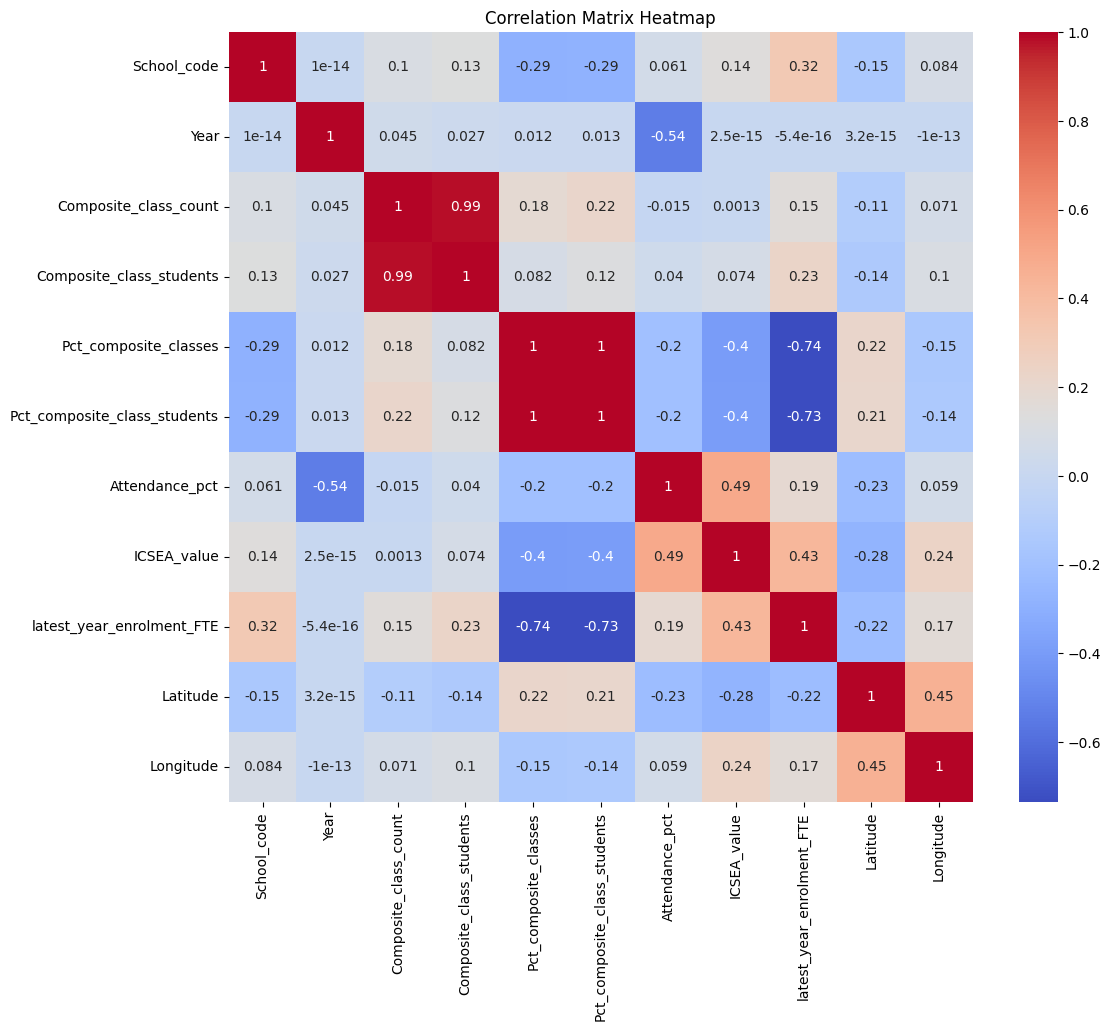

In [8]:
# Execute the SELECT statement
query = "SELECT * FROM nsw_composite_school_attendance_data;"
df = con.execute(query).fetchdf()

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
numeric_df = df[numeric_cols]

# Compute the correlation matrix for numeric columns only
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
print(correlation_matrix)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix Heatmap")
plt.show()